In [1]:
import sys
from pathlib import Path

CURRENT_DIR = Path().resolve()
PROJECT_ROOT = CURRENT_DIR.parent

# 确保 root 在 sys.path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT =", PROJECT_ROOT)


PROJECT_ROOT = /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection


In [3]:
from src.data_processing.data_loader import data_processing, prepare_minutely_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [110]:
stock_list = ["0050", "0056", "2330"]  # 你想分析的股票列表

stock_data_dict = {}

for stock in stock_list:
    print(f"Processing {stock} ...")
    data = data_processing(
        stock=stock,
        data_dir=data_dir,
        trading_days=trading_days,
        minutes_per_day=265,
        months=("202310", "202311", "202312"),
    )
    
    if data is None:
        print(f"{stock}: data_processing 返回 None，跳过")
        continue
    
    stock_data_dict[stock] = data

print("完成，存进 dict 了：", list(stock_data_dict.keys()))


Processing 0050 ...
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/0050_md_202310_202310.csv.gz
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/0050_md_202311_202311.csv.gz
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/0050_md_202312_202312.csv.gz
Minutely data generated.
Total days with full 265 minutes: 63
Processing 0056 ...
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/0056_md_202310_202310.csv.gz
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/0056_md_202311_202311.csv.gz
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/0056_md_202312_202312.csv.gz
Minutely data generated.
Total days with full 265 minutes: 63
Processing 2330 ...
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/2330_md_202310_202310.csv.gz
Loaded /Users/zoer/Documents/25fall/mmm/assignment5/Anomaly-Detection/data/2330_md_20231

## 分析价格的异常波动

In [111]:
def detect_price_jumps_lastpx_rolling5days(
    df,
    minutes_per_day=265,
    window_days=5,
    threshold=5
):
    """
    对单只股票的 minutely_df 检测 jump
    Rolling window = window_days * minutes_per_day
    """
    
    df = df.copy()

    # 1) 单日 diff（不会跨日）
    df["px_ret"] = df.groupby("date")["lastPx"].diff()

    # 2) rolling 计算 5 天 std
    window = minutes_per_day * window_days
    df["sigma"] = (
        df["px_ret"]
        .rolling(window=window, min_periods=window//2)
        .std()
    )

    df["sigma"] = df["sigma"].replace(0, np.nan)

    # 3) z-score
    df["zscore"] = df["px_ret"] / df["sigma"]

    # 4) 判定 jump
    df["jump"] = df["zscore"].abs() > threshold

    return df

def batch_apply_detector(
    stock_data_dict,
    detector_fn,
    df_key="minutely_df",
    verbose=True,
    **detector_kwargs,
):

    result_dict = {}

    for stock, data in stock_data_dict.items():
        if df_key not in data:
            if verbose:
                print(f"[Warning] {stock} 没有 {df_key}，跳过")
            continue

        if verbose:
            print(f"Applying detector for {stock} ...")

        df = data[df_key]
        result_df = detector_fn(df, **detector_kwargs)
        result_dict[stock] = result_df

    if verbose:
        print("Detection finished for:", list(result_dict.keys()))

    return result_dict

In [113]:
jump_dict = batch_apply_detector(
    stock_data_dict,
    detector_fn=detect_price_jumps_lastpx_rolling5days,
    minutes_per_day=265,
    window_days=5,
    threshold=3,
)

Applying detector for 0050 ...
Applying detector for 0056 ...
Applying detector for 2330 ...
Detection finished for: ['0050', '0056', '2330']


In [115]:
jump_dict['0050']

,date,time,lastPx,size,volume,SP5,SP4,SP3,SP2,SP1,...,SV1,BV1,BV2,BV3,BV4,BV5,px_ret,sigma,zscore,jump
dt_index,,,,,,,,,,,,,,,,,,,,,
2023-10-02 09:01:00,2023-10-02,90059399.0,123.65,0.0,215000.0,124.10,124.05,124.00,123.95,123.90,...,91000.0,1000.0,2000.0,121000.0,105000.0,106000.0,NaN,NaN,NaN,False
2023-10-02 09:02:00,2023-10-02,90159819.0,123.75,0.0,251000.0,124.00,123.95,123.90,123.85,123.80,...,16000.0,2000.0,3000.0,210000.0,131000.0,115000.0,0.10,NaN,NaN,False
2023-10-02 09:03:00,2023-10-02,90258756.0,123.75,1000.0,408000.0,124.00,123.95,123.90,123.85,123.80,...,26000.0,4000.0,18000.0,111000.0,261000.0,142000.0,0.00,NaN,NaN,False
2023-10-02 09:04:00,2023-10-02,90359722.0,123.80,2000.0,478000.0,124.00,123.95,123.90,123.85,123.80,...,3000.0,4000.0,118000.0,134000.0,182000.0,141000.0,0.05,NaN,NaN,False
2023-10-02 09:05:00,2023-10-02,90459927.0,123.85,0.0,570000.0,124.05,124.00,123.95,123.90,123.85,...,2000.0,153000.0,167000.0,282000.0,170000.0,52000.0,0.05,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 13:21:00,2023-12-29,132059787.0,135.75,0.0,12031000.0,135.95,135.90,135.85,135.80,135.75,...,271000.0,10000.0,14000.0,235000.0,317000.0,197000.0,0.05,0.045410,1.101077,False
2023-12-29 13:22:00,2023-12-29,132157481.0,135.70,0.0,12049000.0,135.95,135.90,135.85,135.80,135.75,...,283000.0,1000.0,14000.0,236000.0,417000.0,97000.0,-0.05,0.045433,-1.100532,False
2023-12-29 13:23:00,2023-12-29,132256185.0,135.70,1000.0,12086000.0,135.90,135.85,135.80,135.75,135.70,...,40000.0,15000.0,235000.0,319000.0,100000.0,122000.0,0.00,0.045433,0.000000,False


In [116]:
def intraday_event_count(df, col_name, bin_size=5,
                         start_time="09:00", end_time="13:25"):
    """
    统计 df[col_name]==True 的事件，在一天内的时间分布。
    """
    df = df.copy()
    df["minute"] = df.index.hour * 60 + df.index.minute  # 转分钟

    # 只统计异常事件
    event_minutes = df[df[col_name]]["minute"]

    # 区间定义
    h1, m1 = map(int, start_time.split(":"))
    h2, m2 = map(int, end_time.split(":"))

    start_min = h1 * 60 + m1
    end_min   = h2 * 60 + m2

    bins = np.arange(start_min, end_min + 1, bin_size)

    # 统计事件次数
    counts, edges = np.histogram(event_minutes, bins=bins)

    # 返回格式化后的 Series
    index = pd.Index(edges[:-1], name="minute_bin")
    counts_series = pd.Series(counts, index=index, name=f"{col_name}_count")

    return counts_series


In [135]:
def plot_intraday_event_hist_multi_pretty(
    df_dict,
    col_name,
    bin_size=5,
    start_time="09:00",
    end_time="13:25",
    stock_list=None,
):
    """
    更美观的版本：横排多个股票的日内事件分布图
    """

    # 默认取前 3 只股票
    all_stocks = list(df_dict.keys())
    if stock_list is None:
        stock_list = sorted(all_stocks)[:3]
    else:
        stock_list = [s for s in stock_list if s in df_dict]

    n = len(stock_list)
    if n == 0:
        print("⚠️ No valid stocks to plot.")
        return

    # 时间处理
    h1, m1 = map(int, start_time.split(":"))
    h2, m2 = map(int, end_time.split(":"))
    start_min = h1 * 60 + m1
    end_min   = h2 * 60 + m2

    xticks = np.arange(start_min, end_min + 1, 30)
    xtick_labels = [f"{h:02d}:{m:02d}" for h, m in [(t//60, t%60) for t in xticks]]

    # ---------------------------------------------
    # 🎨 样式
    # ---------------------------------------------
    text_color = "#3d405b"   # 深蓝灰
    panel_bg = (244/255, 241/255, 222/255, 0.4)  # 子图背景

    plt.style.use("ggplot")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    axes = axes.flatten()

    # 仅子图背景改色（fig 背景保持白色）
    for ax in axes:
        ax.set_facecolor(panel_bg)

    colors = ["#e07a5f", "#81b29a", "#f2cc8f"]  # 三种颜色

    # ---------------------------------------------
    # 📊 绘图
    # ---------------------------------------------
    for i, stock in enumerate(stock_list):
        ax = axes[i]
        df = df_dict[stock]

        counts = intraday_event_count(
            df,
            col_name=col_name,
            bin_size=bin_size,
            start_time=start_time,
            end_time=end_time,
        )

        ax.bar(
            counts.index,
            counts.values,
            width=bin_size * 0.9,
            align="edge",
            color=colors[i % len(colors)],
            alpha=0.85,
        )

        # 标题
        ax.set_title(
            f"{stock}",
            fontsize=14,
            fontweight="bold",
            color=text_color,
        )

        ax.set_xlabel("Time of Day", color=text_color)
        if i == 0:
            ax.set_ylabel("Event Count", color=text_color)

        ax.set_xticks(xticks)
        ax.set_xticklabels(
            xtick_labels, rotation=40, ha="right", color=text_color
        )

        # tick 颜色
        ax.tick_params(axis="y", colors=text_color)
        ax.tick_params(axis="x", colors=text_color)

        # 边框
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color(text_color)
        ax.spines["bottom"].set_color(text_color)

        ax.grid(axis="y", alpha=0.25, color=text_color)

    # 删除多余 ax
    for j in range(n, 3):
        fig.delaxes(axes[j])

    fig.suptitle(
        f"Intraday Distribution of {col_name} (bin={bin_size} min)",
        fontsize=16,
        fontweight="bold",
        color=text_color,
        y=1.05
    )

    fig.tight_layout()
    plt.show()


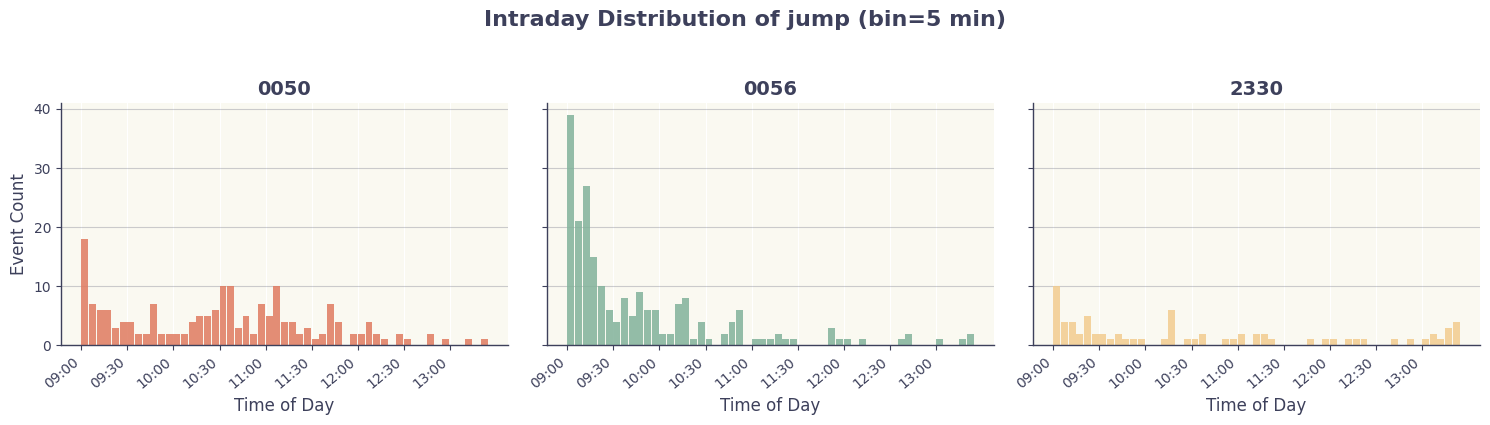

In [136]:
plot_intraday_event_hist_multi_pretty(
    jump_dict,
    col_name="jump",
    bin_size=5,
)

In [137]:
def daily_event_vs_nextday_return(
    df: pd.DataFrame,
    event_col: str,
    price_col: str = "lastPx",
):
    """
    分析：每天某类“事件次数”和下一天日收益的关系。

    输入:
        df: 必须包含
            - price_col  (如 'lastPx')
            - event_col  (bool 或 0/1)
            - 'date'     (没有的话会自动用 index.date 生成)
        event_col: 事件列名，例如 'jump'、'spread_abnormal'
        price_col: 价格列名，默认 'lastPx'

    返回:
        daily_df: DataFrame，列包括
            - date
            - event_count : 当天事件次数
            - ret_today   : 当天开盘到收盘收益
            - ret_next_day: 下一天收益（对齐当前这天）
    """
    df = df.copy()

    if "date" not in df.columns:
        df["date"] = df.index.date

    # 保证是 0/1
    event_flag = df[event_col].astype(int)

    # 日度事件次数
    event_count = event_flag.groupby(df["date"]).sum().rename("event_count")

    # 日度收益
    daily_first = df.groupby("date")[price_col].first()
    daily_last = df.groupby("date")[price_col].last()
    ret_today = (daily_last / daily_first - 1).rename("ret_today")

    daily_df = pd.concat([event_count, ret_today], axis=1).reset_index()
    daily_df = daily_df.sort_values("date")

    # 下一天收益
    daily_df["ret_next_day"] = daily_df["ret_today"].shift(-1)

    return daily_df

def multi_event_ic_table(
    df_dict: dict,
    event_col: str,
    price_col: str = "lastPx",
):
    rows = []

    for stock, df in df_dict.items():
        # 先算单股票的日度表
        daily_df = daily_event_vs_nextday_return(
            df, event_col=event_col, price_col=price_col
        )

        # 丢掉 NaN（主要是最后一天 ret_next_day 为 NaN）
        tmp = daily_df.dropna(subset=["event_count", "ret_today", "ret_next_day"])

        if tmp.shape[0] < 2:
            ic_today = np.nan
            ic_next  = np.nan
        else:
            ic_today = tmp["event_count"].corr(tmp["ret_today"])
            ic_next  = tmp["event_count"].corr(tmp["ret_next_day"])

        row = {
            "stock": stock,
            "n_days": int(tmp.shape[0]),
            "mean_event_count": float(tmp["event_count"].mean()),
            "mean_ret_today": float(tmp["ret_today"].mean()),
            "mean_ret_next_day": float(tmp["ret_next_day"].mean()),
            "ic_today": float(ic_today) if np.isfinite(ic_today) else np.nan,
            "ic_next": float(ic_next) if np.isfinite(ic_next) else np.nan,
        }
        rows.append(row)

    result_df = pd.DataFrame(rows).set_index("stock")

    # 再加一行均值
    mean_row = {
        "stock": "MEAN",
        "n_days": np.nan,
        "mean_event_count": result_df["mean_event_count"].mean(),
        "mean_ret_today": result_df["mean_ret_today"].mean(),
        "mean_ret_next_day": result_df["mean_ret_next_day"].mean(),
        "ic_today": result_df["ic_today"].mean(),
        "ic_next": result_df["ic_next"].mean(),
    }
    result_df = pd.concat(
        [result_df, pd.DataFrame([mean_row]).set_index("stock")]
    )

    return result_df

In [138]:
jump_ic_table = multi_event_ic_table(jump_dict, event_col="jump", price_col="lastPx")
jump_ic_table

,n_days,mean_event_count,mean_ret_today,mean_ret_next_day,ic_today,ic_next
stock,,,,,,
0050,62.0,2.887097,0.000535,0.000462,0.160161,-0.186635
0056,62.0,3.387097,0.000108,-0.000031,-0.012913,-0.001503
2330,62.0,1.177419,0.000238,0.000140,0.026375,0.002569
MEAN,NaN,2.483871,0.000293,0.000190,0.057874,-0.061856


In [167]:
import matplotlib.pyplot as plt
import numpy as np

def plot_event_forward_path_multi_pretty(
    df_dict: dict,
    event_col: str,
    price_col: str = "lastPx",
    horizon: int = 30,
    stock_list=None,
):
    """
    对 df_dict 中的多只股票，画“事件之后未来 horizon 分钟平均路径”，横着 3 幅子图。

    参数：
        df_dict   : {stock: DataFrame}，每个 df 至少包含 event_col & price_col
        event_col : 事件列名，如 'jump'、'spread_abnormal'
        price_col : 价格列名，如 'lastPx'
        horizon   : 向后看的分钟数
        stock_list: 要画的股票列表（最多 3 个）。None 则默认取 df_dict 前 3 个 key。
    """

    all_stocks = list(df_dict.keys())
    if stock_list is None:
        stock_list = sorted(all_stocks)[:3]
    else:
        stock_list = [s for s in stock_list if s in df_dict]

    n = len(stock_list)
    if n == 0:
        print("⚠️ No valid stocks to plot.")
        return

    # 样式设置（和你前面保持一致）
    text_color = "#3d405b"
    panel_bg   = (244/255, 241/255, 222/255, 0.55)   # 半透明 #f4f1de
    line_color = "#e07a5f"

    plt.style.use("ggplot")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axes = axes.flatten()

    # 设置子图背景
    for ax in axes:
        ax.set_facecolor(panel_bg)

    for i, stock in enumerate(stock_list):
        ax = axes[i]
        df = df_dict[stock]

        res = event_forward_path(
            df,
            event_col=event_col,
            price_col=price_col,
            horizon=horizon,
        )

        ax.plot(
            res["offsets"],
            res["mean_path"],
            color=line_color,
            linewidth=1.8,
            label=f"{stock} (n={res['n_events']})",
        )

        ax.axhline(0, color=text_color, linestyle="--", linewidth=1, alpha=0.7)

        ax.set_title(
            f"{stock}",
            fontsize=14,
            fontweight="bold",
            color=text_color,
        )
        ax.set_xlabel("Minutes after event", color=text_color)
        if i == 0:
            ax.set_ylabel("Average return since event", color=text_color)

        ax.tick_params(axis="x", colors=text_color)
        ax.tick_params(axis="y", colors=text_color)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color(text_color)
        ax.spines["bottom"].set_color(text_color)

        ax.grid(axis="y", alpha=0.25, color=text_color)
        ax.legend(frameon=False, fontsize=9, loc="best")

    # 删除没用到的子图
    for j in range(n, 3):
        fig.delaxes(axes[j])

    fig.suptitle(
        f"Average {price_col} path after {event_col}",
        fontsize=16,
        fontweight="bold",
        color=text_color,
        y=1.05,
    )

    fig.tight_layout()
    plt.show()


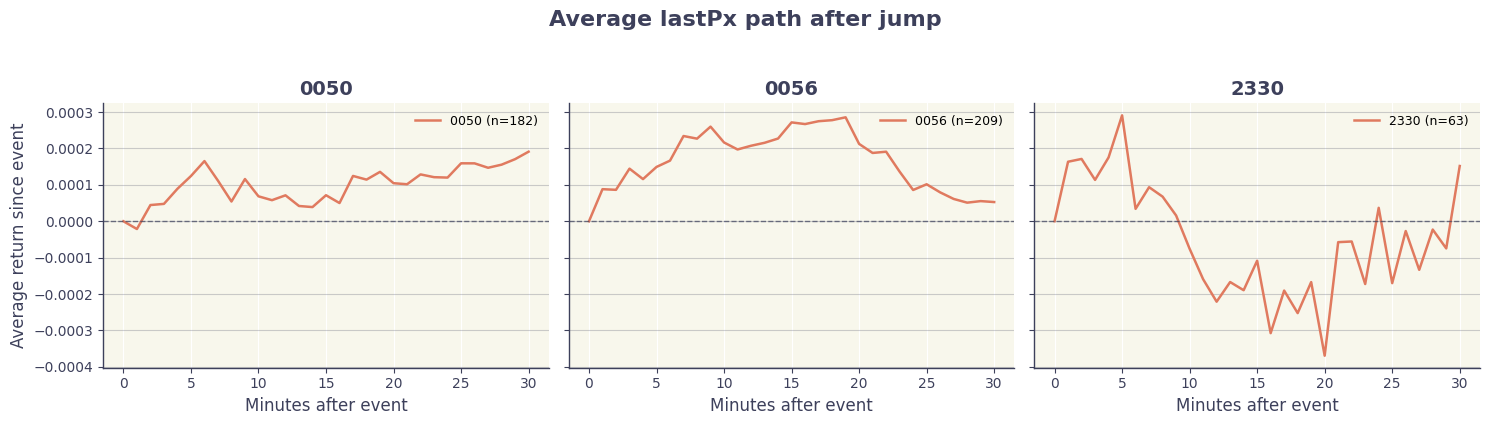

In [168]:
plot_event_forward_path_multi_pretty(
    jump_dict,
    event_col="jump",
    price_col="lastPx",
    horizon=30,
)


In [141]:
def event_forward_path_by_direction(
    df: pd.DataFrame,
    event_col: str,
    ret_col: str = "px_ret",
    price_col: str = "lastPx",
    horizon: int = 30,
):
    """
    通用版：分方向事件之后未来价格路径（单股票）

    输入:
        df: 分钟级 DataFrame，index 为时间戳，至少包含：
            - event_col  : 事件（bool / 0,1）
            - ret_col    : 用于判断方向的“当期收益”（>0 为 up，<0 为 down）
            - price_col  : 价格，用于画路径
        event_col: 事件列名（如 'jump', 'spread_abnormal'）
        ret_col  : 方向列名（如 'px_ret'）
        price_col: 价格列名（如 'lastPx'）
        horizon  : 向后看的分钟数

    返回:
        result: dict，包含 'up' 和 'down' 两个子 dict：
            - offsets   : [0..horizon]
            - paths     : (n_events, horizon+1)
            - mean_path : 平均路径
            - n_events  : 事件个数
    """
    df = df.copy()
    if "date" not in df.columns:
        df["date"] = df.index.date

    df[event_col] = df[event_col].astype(bool)

    offsets = np.arange(horizon + 1)

    def _collect_paths(direction_sign: str):
        """
        direction_sign: 'up' -> ret_col > 0
                        'down' -> ret_col < 0
        """
        paths = []

        for d, day_df in df.groupby("date"):
            day_df = day_df.sort_index()
            prices = day_df[price_col].values
            events = day_df[event_col].values
            rets   = day_df[ret_col].values

            if direction_sign == "up":
                mask = (events) & (rets > 0)
            else:
                mask = (events) & (rets < 0)

            idx = np.where(mask)[0]
            for j in idx:
                if j + horizon >= len(day_df):
                    continue
                base_price = prices[j]
                future_prices = prices[j:j + horizon + 1]
                path = future_prices / base_price - 1.0
                paths.append(path)

        if len(paths) == 0:
            return {
                "offsets": offsets,
                "paths": np.empty((0, horizon + 1)),
                "mean_path": np.zeros(horizon + 1),
                "n_events": 0,
            }

        paths = np.vstack(paths)
        mean_path = paths.mean(axis=0)
        return {
            "offsets": offsets,
            "paths": paths,
            "mean_path": mean_path,
            "n_events": paths.shape[0],
        }

    up_res = _collect_paths("up")
    down_res = _collect_paths("down")

    return {"up": up_res, "down": down_res}


def plot_event_forward_path_by_direction_multi(
    df_dict: dict,
    event_col: str,
    ret_col: str = "px_ret",
    price_col: str = "lastPx",
    horizon: int = 30,
    stock_list=None,
):
    """
    对 df_dict 中的多只股票，画“向上/向下事件之后的平均价格路径”，横着三幅子图。

    参数：
        df_dict   : {stock: DataFrame}
        event_col : 事件列名（如 'jump'）
        ret_col   : 方向列名（如 'px_ret'）
        price_col : 价格列名（如 'lastPx'）
        horizon   : 向后分钟数
        stock_list: 要画的股票代码列表（最多三只），默认取字典里前 3 个
    """
    all_stocks = list(df_dict.keys())
    if stock_list is None:
        stock_list = sorted(all_stocks)[:3]
    else:
        stock_list = [s for s in stock_list if s in df_dict]

    n = len(stock_list)
    if n == 0:
        print("⚠️ No valid stocks to plot.")
        return

    # 样式
    text_color = "#3d405b"
    panel_bg   = (244/255, 241/255, 222/255, 0.4)   # 半透明 #f4f1de
    up_color   = "#e07a5f"
    down_color = "#81b29a"

    plt.style.use("ggplot")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    axes = axes.flatten()

    # 子图背景
    for ax in axes:
        ax.set_facecolor(panel_bg)

    for i, stock in enumerate(stock_list):
        ax = axes[i]
        df = df_dict[stock]

        res_dir = event_forward_path_by_direction(
            df,
            event_col=event_col,
            ret_col=ret_col,
            price_col=price_col,
            horizon=horizon,
        )

        up_res = res_dir["up"]
        down_res = res_dir["down"]

        ax.plot(
            up_res["offsets"],
            up_res["mean_path"],
            label=f"Up (n={up_res['n_events']})",
            color=up_color,
            linewidth=1.8,
        )
        ax.plot(
            down_res["offsets"],
            down_res["mean_path"],
            label=f"Down (n={down_res['n_events']})",
            color=down_color,
            linewidth=1.8,
        )

        ax.axhline(0, color=text_color, linestyle="--", linewidth=1, alpha=0.7)

        ax.set_title(
            f"{stock}",
            fontsize=14,
            fontweight="bold",
            color=text_color,
        )
        ax.set_xlabel("Minutes after event", color=text_color)
        if i == 0:
            ax.set_ylabel("Average return since event", color=text_color)

        ax.tick_params(axis="x", colors=text_color)
        ax.tick_params(axis="y", colors=text_color)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_color(text_color)
        ax.spines["bottom"].set_color(text_color)

        ax.grid(axis="y", alpha=0.25, color=text_color)
        ax.legend(frameon=False, fontsize=9, loc="best")

    # 多余子图删掉
    for j in range(n, 3):
        fig.delaxes(axes[j])

    fig.suptitle(
        f"Average {price_col} path after {event_col} (by direction)",
        fontsize=16,
        fontweight="bold",
        color=text_color,
        y=1.05,
    )

    fig.tight_layout()
    plt.show()


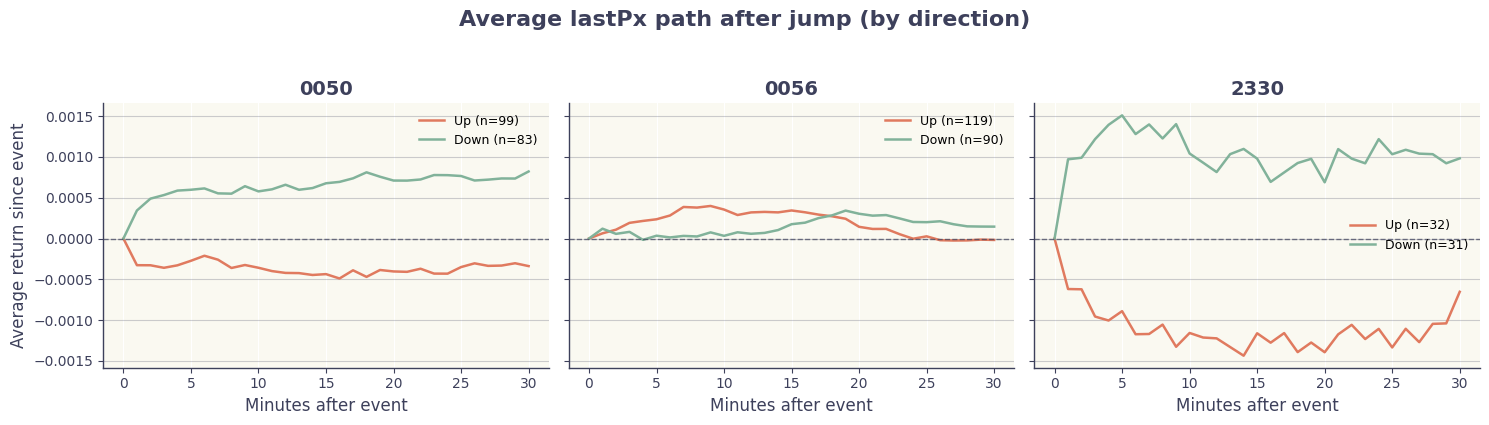

In [142]:
# jump_dict: {stock: jump_df}，里面有 'jump', 'px_ret', 'lastPx'
plot_event_forward_path_by_direction_multi(
    jump_dict,
    event_col="jump",
    ret_col="px_ret",
    price_col="lastPx",
    horizon=30,
)


🟣（2）价格“卡住”（stale price）

很长时间不更新 lastPx / midPx

尤其在高流动性品种更显著

或 Bid / Ask 一侧不变但另一侧波动

**典型 abnormal：**报价系统卡顿、交易所延迟、数据异常。

🧠 2. 流动性 & 订单簿深度（Liquidity / Order Book Depth）异常
🟣（1）Bid-Ask Spread 异常变宽

正常：0.5 ~ 1 tick

异常：突然扩大到 5 tick、10 tick、甚至更大

或长时间 spread >> 正常区间

表示市场瞬间缺流动性。

In [162]:
def detect_abnormal_spread(
    df: pd.DataFrame,
    tick_size: float = 0.01,
    abs_tick_thresh: float = 5,   # 绝对：>= 5 tick
    z_thresh: float = 3.0         # 相对：比“常态”高 3σ
):
    """
    检测 Bid-Ask Spread 异常变宽的分钟。

    参数
    ----
    df : DataFrame
        需要列：
        - SP1, BP1
        index 为时间戳（分钟）
    tick_size : float
        最小价格跳动单位，用来把 spread 换成 tick 数。
    abs_tick_thresh : float
        绝对阈值：spread_ticks >= 这个值，认为“太宽”。
    z_thresh : float
        相对阈值：spread_z >= 这个值，认为“相对于该时间点的常态太夸张”。

    返回
    ----
    df_out : DataFrame
        在原 df 基础上增加：
        - spread
        - spread_ticks
        - spread_med       （该时间点历史中位数）
        - spread_std
        - spread_z
        - spread_abnormal  （True/False）
    """
    df = df.copy()
    df["px_ret"] = df.groupby("date")["lastPx"].diff()

    # 1. 当前 spread（价格 & tick）
    df["spread"] = df["SP1"] - df["BP1"]
    df["spread_ticks"] = df["spread"] / tick_size

    # 2. 按一天中的时间点估计“正常 spread”
    df["hhmm"] = df.index.strftime("%H:%M")
    stats = (
        df.groupby("hhmm")["spread_ticks"]
          .agg(["median", "std"])
          .rename(columns={"median": "spread_med", "std": "spread_std"})
    )
    df = df.join(stats, on="hhmm")

    # 避免 std 为 0
    df["spread_std"] = df["spread_std"].replace(0, np.nan)

    # 3. 计算 z-score
    df["spread_z"] = (df["spread_ticks"] - df["spread_med"]) / df["spread_std"]

    # 4. 定义异常：同时满足“绝对宽”和“相对异常”
    cond_abs = df["spread_ticks"] >= abs_tick_thresh
    cond_rel = df["spread_z"] >= z_thresh

    df["spread_abnormal"] = cond_abs & cond_rel

    return df


In [163]:
spread_dict = batch_apply_detector(
    stock_data_dict,
    detector_fn=detect_abnormal_spread,
    z_thresh=3,
)

Applying detector for 0050 ...
Applying detector for 0056 ...
Applying detector for 2330 ...
Detection finished for: ['0050', '0056', '2330']


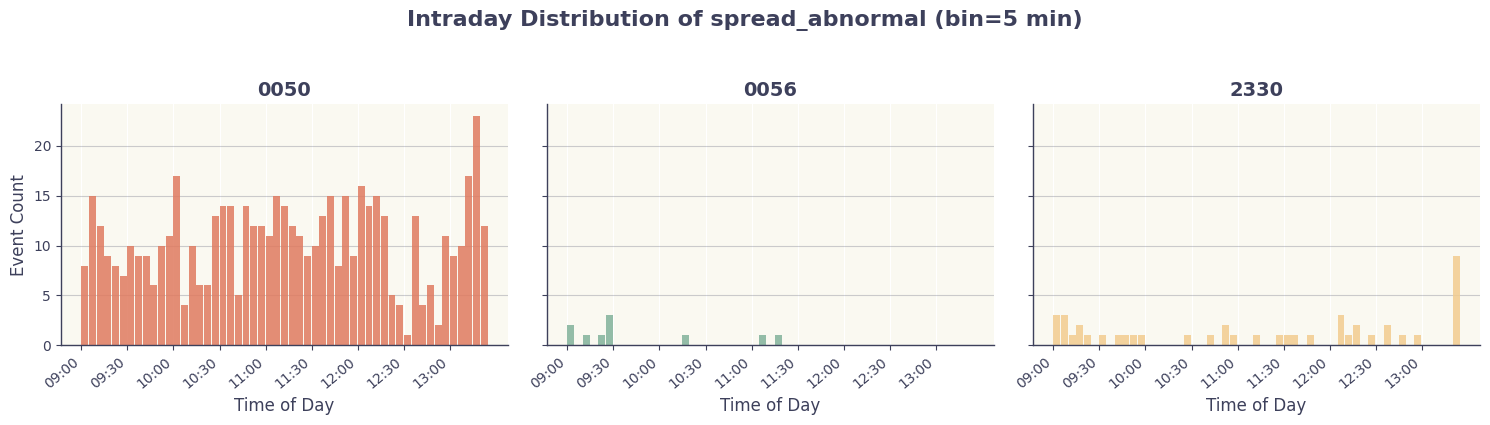

In [164]:
plot_intraday_event_hist_multi_pretty(
    spread_dict,
    col_name="spread_abnormal",
    bin_size=5,
)

In [165]:
spread_ic_table = multi_event_ic_table(spread_dict, event_col="spread_abnormal", price_col="lastPx")
spread_ic_table

,n_days,mean_event_count,mean_ret_today,mean_ret_next_day,ic_today,ic_next
stock,,,,,,
0050,62.0,8.919355,0.000535,0.000462,-0.017091,-0.161853
0056,62.0,0.161290,0.000108,-0.000031,-0.147063,0.138368
2330,62.0,0.709677,0.000238,0.000140,-0.059286,0.144394
MEAN,NaN,3.263441,0.000293,0.000190,-0.074480,0.040303


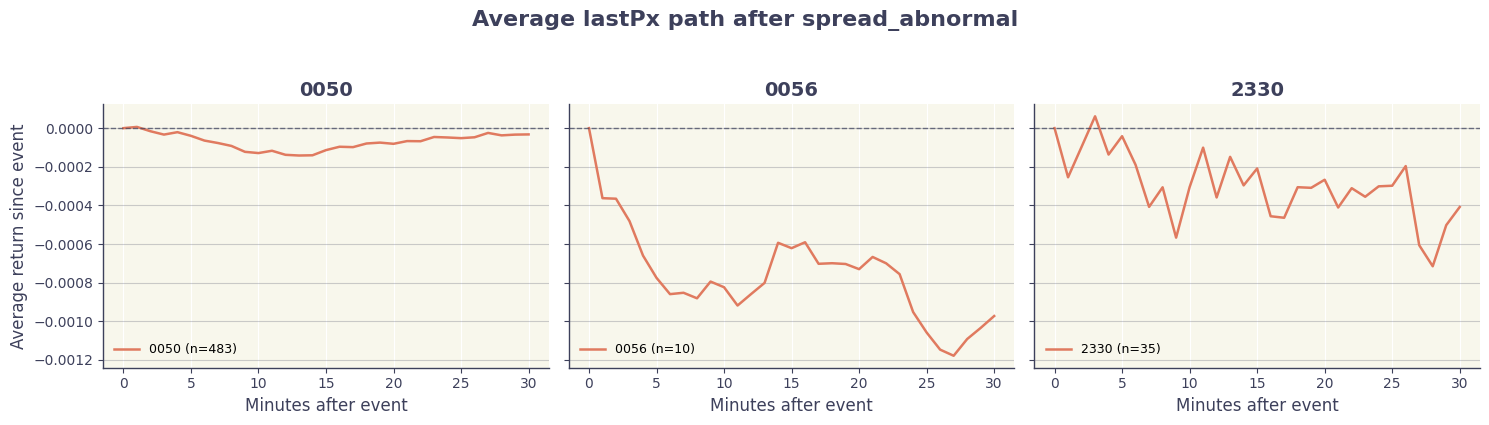

In [169]:
plot_event_forward_path_multi_pretty(
    spread_dict,
    event_col="spread_abnormal",
    price_col="lastPx",
    horizon=30,
)


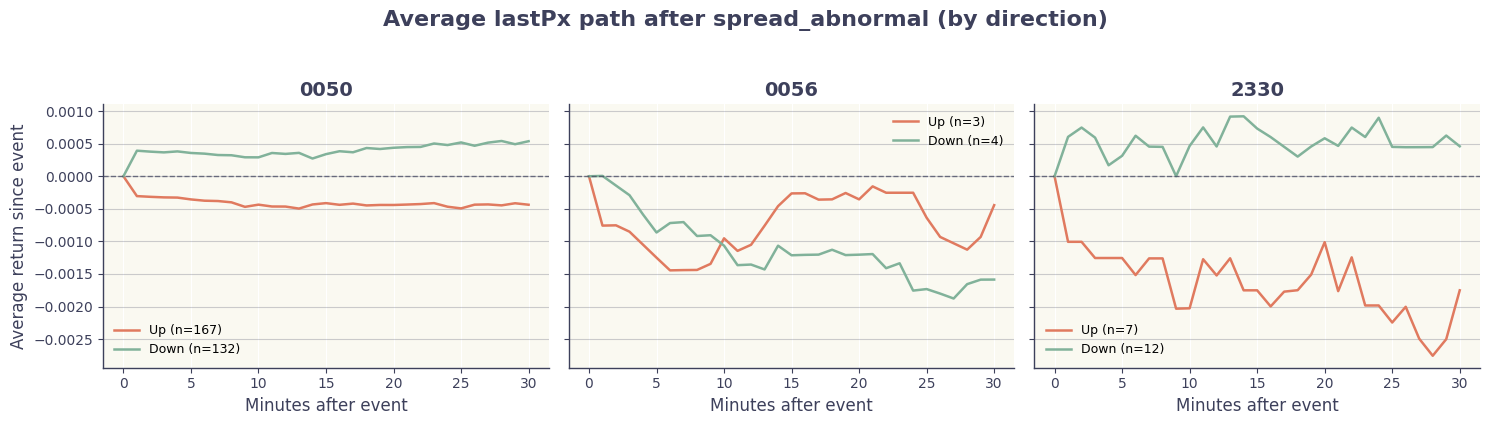

In [166]:
# jump_dict: {stock: jump_df}，里面有 'jump', 'px_ret', 'lastPx'
plot_event_forward_path_by_direction_multi(
    spread_dict,
    event_col="spread_abnormal",
    ret_col="px_ret",
    price_col="lastPx",
    horizon=30,
)

🟣（2）盘口深度崩塌（Depth Collapse）

例如：

SV1/BV1（第一档数量）突然下降到接近 0

5-level depth 总量骤然减少

这通常是：

大机构撤单

交易商停止做市

市场受到冲击

abnormal 的信号非常明显。

🟣（3）盘口“极端不平衡”（Order Book Imbalance）

观察：

pressure_1 = (BV1 - SV1)/(BV1 + SV1)
pressure_5 = (BV_SUM - SV_SUM)/(BV_SUM + SV_SUM)


如果：

imbalance → +1 或 -1 附近

而且持续较长时间（不是瞬时 spike）

说明买/卖一侧几乎被清空。

这也被视为异常。

🧠 3. 交易行为（Trades）异常
🟣（1）Trade Size 畸大（突然出现极巨量成交）

例如：

平常 size 在 1–50 手之间

某分钟突然出现 5000→10000 手

往往表示：

清算

算法扫盘

大型机构的“紧急平仓”

数据错误

🟣（2）Trade Frequency 异常减少（无成交状态）

交易频率非常低或突然断档

lastPx 一直不更新

在高流动资产上 → 明显 abnormal

🟣（3）成交价格公开偏离（Trade-through）

例如：

有时 lastPx 买入价高于 SP1（不应该）

或卖出价低于 BP1

若不是 hidden order → 数据异常。

🧠 4. 价格 + 盘口联动异常（Behavioral Microstructure）

最重要也最“主观”的判断：
价格、深度、成交行为之间的“不一致性”。

例子：

🟣（1）价格持续上涨，但买盘深度在急剧减少

→ 不符合供需关系，可能是 spoofing、拉抬。

🟣（2）价差稳定但成交激增

→ 手续费套利？机器人错误？

🟣（3）盘口深度巨量但价格剧烈跳动

→ 虚假挂单 / 诱骗订单（spoofing）

这些相互矛盾行为就是 “market microstructure anomalies”。

🧠 5. 序列结构本身异常（Time Series Shape）

GAN 的判别器其实就在抓这些：

🟣（1）某一日的 LOB 行程与训练分布不一致

表现为：

波动率特征完全不同

Depth 的 autocorrelation 异常断裂

spread 序列形状怪异

LOB pressure 序列呈现非正常震荡

这类属于 时序形态异常（shape anomaly）
所以 GAN 很擅长抓。

🔥 7. 总结：哪些 LOB 行为属于 “abnormal”

✔ spread 异常变宽（由 1 tick → 10 tick）
✔ 买卖一侧深度崩塌（几乎清空）
✔ LOB imbalance 接近 ±1 且持续
✔ 成交量极端 spike
✔ midPx 或 lastPx 跳跃（jump）
✔ 价格静止很久或异常震荡（flat / flickering）
✔ 成交价穿透盘口（trade-through）
✔ 盘口结构与价格行为严重矛盾
✔ 盘口深度、价差、成交量序列形状与“正常日”不一致

这些都是 microstructure 业内典型的 异常 LOB 行为。

需要做的事情
一个是看abnormal出现的分钟分布 看看是否集中在开盘